In [5]:
#### To confirm that you have the latest versions of these packages, uncomment and run the following command.
#!pip install numpy pandas matplotlib sklearn ipywidgets IPython --upgrade

# To generate and store data.
import numpy as np
import pandas as pd

# To visualize data.
import matplotlib.pyplot as plt

# To fit linear regression model.
from sklearn.linear_model import LinearRegression

# To allow interactive plot.
from ipywidgets import *
from IPython.display import display

# There is a SciPy issue that won't affect our work, but a warning exists
# and an update is not imminent.
import warnings
warnings.filterwarnings(action="ignore")

# To render plots in the notebook.
%matplotlib inline

In [6]:
# Generate data and store in a dataframe.

np.random.seed(42)

age = np.random.uniform(20, 60, size = 100)
income = 15000 + 750 * age + np.random.normal(0, 20000, size = 100)
income = [i if i >= 0 else 0 for i in income]

df = pd.DataFrame({'income':income,
                   'age': age})

In [7]:
# Create three functions to model missingness according to certain patterns.

def create_mcar_column(df, missing_column = 'income', p_missing = 0.01, random_state = 42):
    """
    Creates missingness indicator column, where data are MCAR (missing completely at random).
    
    User must specify:
        df = the pandas DataFrame the user wants to read in for analysis
        column = the name of the column in df that is missing
        p_missing = the proportion of observations that are missing
        
    Function returns:
        mcar_column = a column that indicates whether data are missing, assuming MCAR
    """
    np.random.seed(random_state)
    
    mcar_indices = [df.sample(n = 1).index[0] for i in range(round(p_missing * df.shape[0]))]
    
    while len(set(mcar_indices)) < round(p_missing * df.shape[0]):
        mcar_indices.append(df.sample(n = 1).index[0])
    
    mcar_column = [1 if i in mcar_indices else 0 for i in range(df.shape[0])]
    
    return mcar_column

def create_mar_column(df, missing_column = 'income', depends_on = 'age', method = 'linear', p_missing = 0.01, random_state = 42):
    """
    Creates missingness indicator column, where data are MAR (missing at random).
    
    User must specify:
        df = the pandas DataFrame the user wants to read in for analysis
        missing_column = the name of the column in df that is missing
        depends_on = the name of the column in df which affects the missingness
        method = 'linear' or 'quadratic'
            - 'linear' means the probability of missingness is linearly related to the depends_on variable
            - 'quadratic' means the probability of missingness is quadratically related to the depends_on variable
        p_missing = the proportion of observations that are missing
        
    Function returns:
        mar_column = a column that indicates whether data are missing, assuming MAR
    """
    np.random.seed(random_state)
    
    if method == 'linear':
        mar_indices = [df.sample(n = 1, weights = depends_on).index[0] for i in range(round(p_missing * df.shape[0]))]

        while len(set(mar_indices)) < round(p_missing * df.shape[0]):
            mar_indices.append(df.sample(n = 1, weights = depends_on).index[0])
    
    elif method == 'quadratic':
        mar_indices = [df.sample(n = 1, weights = df[depends_on] ** 2).index[0] for i in range(round(p_missing * df.shape[0]))]

        while len(set(mar_indices)) < round(p_missing * df.shape[0]):
            mar_indices.append(df.sample(n = 1, weights = df[depends_on] ** 2).index[0])

    mar_column = [1 if i in mar_indices else 0 for i in range(df.shape[0])]
        
    return mar_column

def create_nmar_column(df, missing_column = 'income', method = 'linear', p_missing = 0.01, random_state = 42):
    """
    Creates missingness indicator column, where data are NMAR (not missing at random).
    
    User must specify:
        df = the pandas DataFrame the user wants to read in for analysis
        missing_column = the name of the column in df that is missing
        method = 'linear' or 'quadratic'
            - 'linear' means the probability of missingness is linearly related to the depends_on variable
            - 'quadratic' means the probability of missingness is quadratically related to the depends_on variable
        p_missing = the proportion of observations that are missing
        
    Function returns:
        nmar_column = a column that indicates whether data are missing, assuming NMAR
    """
    np.random.seed(random_state)
    
    if method == 'linear':
        nmar_indices = [df.sample(n = 1, weights = missing_column).index[0] for i in range(round(p_missing * df.shape[0]))]

        while len(set(nmar_indices)) < round(p_missing * df.shape[0]):
            nmar_indices.append(df.sample(n = 1, weights = missing_column).index[0])
    
    elif method == 'quadratic':
        nmar_indices = [df.sample(n = 1, weights = df[missing_column] ** 2).index[0] for i in range(round(p_missing * df.shape[0]))]

        while len(set(nmar_indices)) < round(p_missing * df.shape[0]):
            nmar_indices.append(df.sample(n = 1, weights = df[missing_column] ** 2).index[0])
            
    nmar_column = [1 if i in nmar_indices else 0 for i in range(df.shape[0])]
    
    return nmar_column

In [8]:
def generate_scatterplot(p_missing, missing_type, method = 'linear', missing_column = 'income', depends_on = 'age'):
    # Generate one plot.
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (16,9))

    # Set labels and axes.
    ax.set_xlabel("Age", position = (0,0), ha = 'left', fontsize = 25, color = 'grey', alpha = 0.85)
    ax.set_ylabel("Income", position = (0,1), ha = 'right', va = 'top', fontsize = 25, rotation = 0, color = 'grey', alpha = 0.85)
    
    ax.set_ylim([-1000, 100000])
    
    # Generate data with proportion p missing.
    if missing_type == 'MCAR':
        df['missingness'] = create_mcar_column(df,
                                               missing_column = missing_column,
                                               p_missing = p_missing)
    elif missing_type == 'MAR':
        df['missingness'] = create_mar_column(df,
                                              missing_column = missing_column,
                                              depends_on = depends_on,
                                              method = method,
                                              p_missing = p_missing)
    
    elif missing_type == 'NMAR':
        df['missingness'] = create_nmar_column(df,
                                               missing_column = missing_column,
                                               method = method,
                                               p_missing = p_missing)
    
    # Generate scatterplot.
    ax.scatter(df['age'][df['missingness'] == 0], df['income'][df['missingness'] == 0], s = 35, color = '#185fad', alpha = 0.75, label = 'Observed')
    ax.scatter(df['age'][df['missingness'] == 1], df['income'][df['missingness'] == 1], s = 35, color = 'grey', alpha = 0.25, label = '')
    
    # Generate lines of best fit based on observed and missing values.
    x = np.linspace(20, 60)
    ax.plot(x, 15000 + 750 * x, c = 'orange', alpha = 0.7, label = '"True" Line', lw = 3)
    model = LinearRegression().fit(df[['age']][df['missingness'] == 0], df['income'][df['missingness'] == 0])
    ax.plot(x, model.intercept_ + model.coef_ * x, c = '#185fad', alpha = 0.7, label='Observed Line', lw = 3)

    # Generate title and legend.
    ax.set_title('Type of Missing Data: %s \nProportion Missing: %s' % (missing_type, p_missing), position = (0,1), ha = 'left', fontsize = 25)
    ax.legend(prop={'size': 20}, loc = 2)
    
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show();

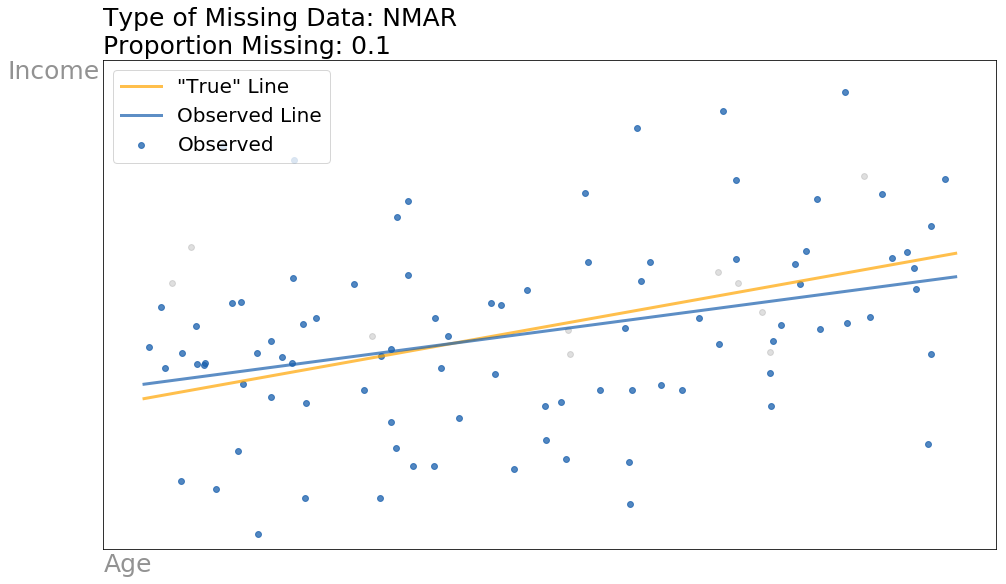

In [9]:
generate_scatterplot(p_missing=0.1, missing_type = 'NMAR', method = 'quadratic')

In [10]:
def plot_interact(p_missing = 0, missing_type = 'NMAR', method = 'quadratic'):
    generate_scatterplot(p_missing, missing_type, method, missing_column = 'income', depends_on = 'age')
    
interact(plot_interact, p_missing = (0, 0.99, 0.05), missing_type = ['MCAR','MAR','NMAR'], method = ['linear','quadratic']);

A Jupyter Widget